# GWAS interpretation
## In this notebook, we will explore and interpret our GWAS results.
### Topics we will cover:
Reading and interpreting Manhattan and QQ plots  
Multiple testing correction  
The effects of population structure correction   
Why we take minor allele frequency (MAF) cutoffs in our SNPs data  
Use caution when interpreting the relationship between p-value and effect size

# 1.  Setup

## 1a. Prepare environment
Loading packages and functions into R

In [1]:
# install.packages("qqman")
# install.packages('gridExtra')
library(gridExtra)
library(ggplot2)
library(qqman)

# Load external R functions for creating a Manhattan plot and Q-Q plots
source("./functions/ggmanhattan.R")



For example usage please run: vignette('qqman')



Citation appreciated but not required:

Turner, (2018). qqman: an R package for visualizing GWAS results using Q-Q and manhattan plots. Journal of Open Source Software, 3(25), 731, https://doi.org/10.21105/joss.00731.





## 1b. Define input variables

In [2]:
path.figures = './figures/'
path.retults = "./results/"
path.prerun = './prerun_results/'

# s.phenotype = 'subset_flowering_time_16_gwas'
# s.phenotype = 'flowering_time_16_gwas'
# s.phenotype = 'cadmium_concentration_gwas'
s.phenotype = 'rosette_color_gwas'


# results from population structure corrected GWAS
file.results = paste(path.retults, s.phenotype, ".csv", sep = '')

# results from non-population structure corrected GWAS
file.results.nc = paste(path.retults, s.phenotype, "_nc.csv", sep = '')

# results from GWAS using a minor allele frequency cutoff of 1% rather than 10%
# this GWAS has already been run for you
### DO NOT change this file during independent work ###
file.results.maf1 = paste(path.prerun, s.phenotype, '_maf1.csv', sep = '')


# 2.  Load GWAS results
Load the results files we generated in the GWAS notebook (2_GWAS.ipynb).
Each row in these files represents one SNP and the columns are: chromosome (chr), position (pos), p-value (pvalue), minor allele frequency (maf), and effect size (GVE).  The first two files were generated in the previous notebook, but the GWAS in the third file has already been done for you (results_file_maf1).

In [3]:
results <- read.csv(file=file.results, stringsAsFactors=FALSE)
results.nc <- read.csv(file=file.results.nc, stringsAsFactors=FALSE)
results.maf1 <- read.csv(file=file.results.maf1, stringsAsFactors=FALSE)

# Make sure what we've loaded is as expected
dim(results)
head(results)

dim(results.nc)
head(results.nc)

dim(results.maf1) ### to save space, I only outputted the chromosome, position, and p-value for this GWAS, so it only has 3 columns
head(results.maf1)

[1] 124002      5

,chr,pos,pvalue,maf,GVE
,<int>,<int>,<dbl>,<dbl>,<dbl>
1,1,502,0.7305862,0.3891892,-5.260338e-04
2,1,730,0.9864303,0.4054054,2.589565e-05
3,1,1260,0.9878239,0.4270270,-2.262744e-05
4,1,1974,0.4805187,0.1243243,-1.548162e-03
5,1,8193,0.7597490,0.4000000,4.757410e-04
6,1,17689,0.2305383,0.2432432,1.863590e-03


[1] 124002      5

,chr,pos,pvalue,maf,GVE
,<int>,<int>,<dbl>,<dbl>,<dbl>
1,1,502,0.83023972,0.3891892,0.0002459198
2,1,730,0.50221982,0.4054054,0.0007639150
3,1,1260,0.46790205,0.4270270,0.0008201857
4,1,1974,0.47166106,0.1243243,0.0012192332
5,1,8193,0.34726244,0.4000000,0.0010717779
6,1,17689,0.03323772,0.2432432,0.0027586968


[1] 309308      3

,chr,pos,pvalue
,<int>,<int>,<dbl>
1,1,502,0.7305862
2,1,730,0.9864303
3,1,821,0.9286430
4,1,1260,0.9878239
5,1,1974,0.4805187
6,1,4793,0.2178402


# 3. Manhattan plot
We will start by viewing the p-values for every individual SNP across the genome in a plot know as a __*Manhattan plot*__:
- Each point in this plot represents one SNP
- The x-axis is the genomic position of the SNP
- The y-axis is the **-log10 of the p-value** for the SNP-phenotype association test (the GWAS). 

Manhattan plots use the -log10 so the smallest p-values become more visible.  The point colors alternate to denote the different chromosomes. Can you see "peaks" of SNPs that rise above the background?  What does this plot suggest about the architecture of the trait (simple versus complex)?

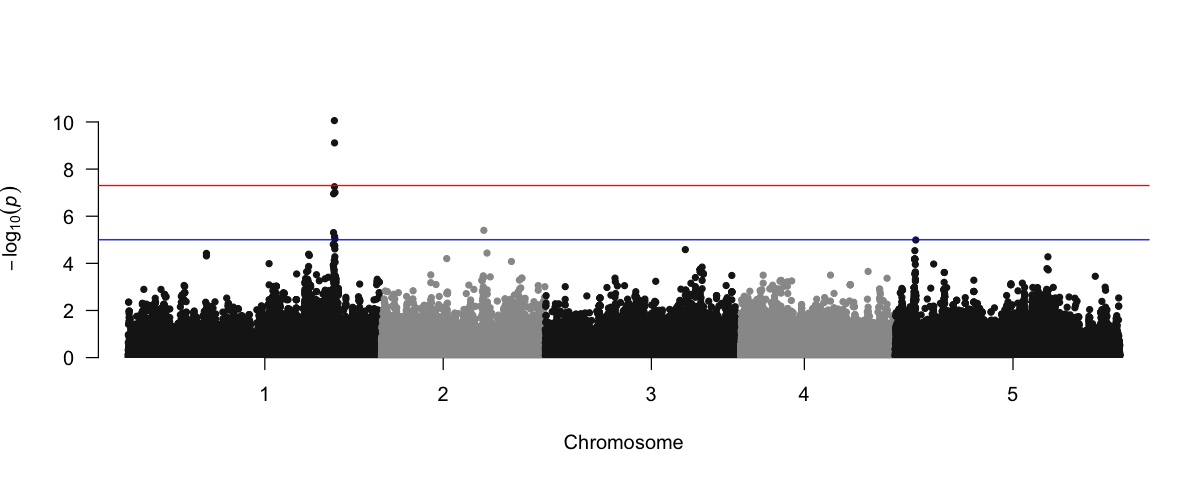

In [4]:
options(repr.plot.width=10, repr.plot.height=4) # Set the default plot width and height for this cell

results$snp = paste('chr', results$chr, 'pos', results$pos, sep = '_')

manhattan(results, chr = "chr",
  bp = "pos",
  p = "pvalue",
  snp = "snp",
  col = c("gray10", "gray60"))

pdf 
  2

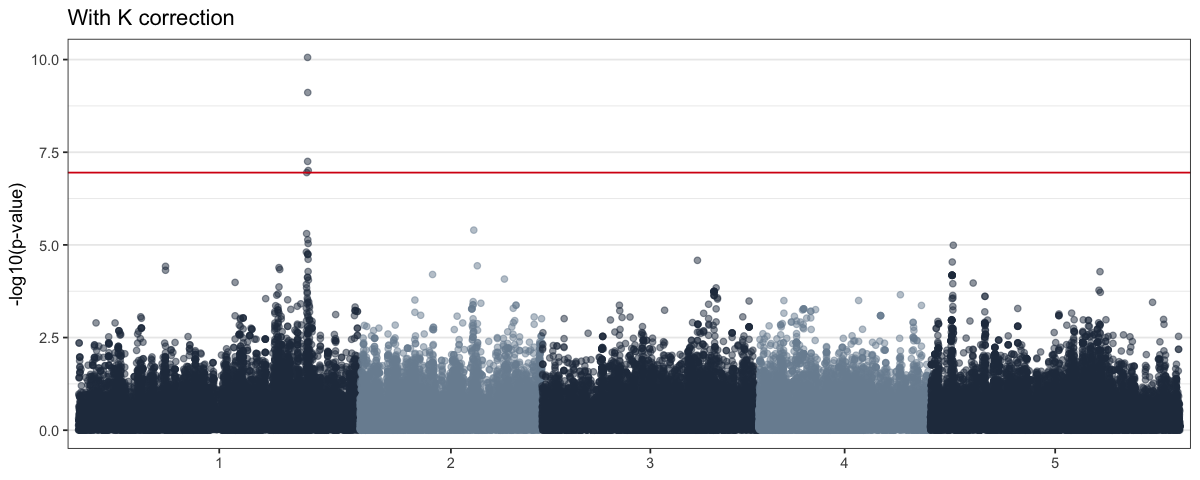

In [5]:
# source("./functions/ggmanhattan.R")
options(repr.plot.width=10, repr.plot.height=4)

p.man = ggmanhattan(results, s.title="With K correction")
p.man 

# Save the plot
pdf(paste(path.figures, 'manhattan_',s.phenotype,'_with_kinship.pdf', sep = ''), width = 8, height = 4)
p.man
dev.off()


# 4. Multiple testing
The red dotted line in the Manhattan plot marks the Bonferroni significance cutoff. Since we perform so many tests in a GWAS (one per SNP), we need to apply a method to correct the p-value threshold so we don't identify too many false positive SNPs. The easiest method is the Bonferroni correction, which is done by dividing a typical significance threshold (usually 0.05) by the number of tests done (i.e. the number of SNPs tested). SNPs above the dotted line in this Manhattan plot would be significant above the Bonferroni cutoff.  There are none in the case of our subset flowering time GWAS!

However, the Bonferroni method is an extremely conservative strategy for multiple testing, since it implies that all tests are independent (which we know is untrue - there is LD between SNPs). There are many other methods! Two less conservative types of multiple testing correction that are also applied to GWAS are (1) FDR (false discovery rate) and (2) permutation.

# 5. The effects of population structure correction
To begin to understand how population structure affects GWAS, generate the following two plots:

pdf 
  2

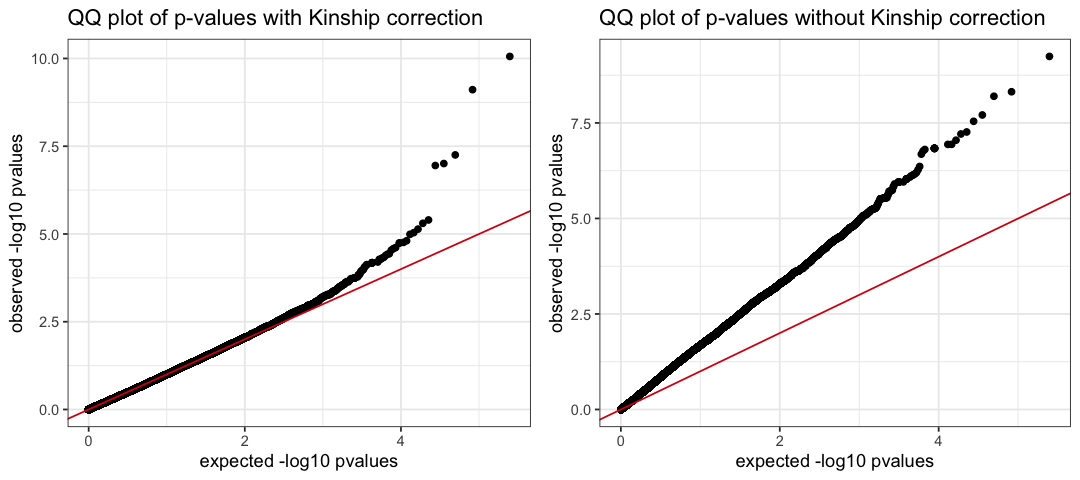

In [6]:
options(repr.plot.width=9, repr.plot.height=4)

p.qq = qqplot(results, s.title = "QQ plot of p-values with Kinship correction")
p.qq.nc = qqplot(results.nc, s.title = "QQ plot of p-values without Kinship correction")

grid.arrange(p.qq, p.qq.nc, ncol=2)

# Save plot
pdf(paste(path.figures, 'qq_',s.phenotype,'_kinship.pdf', sep = ''), width = 9, height = 4)
grid.arrange(p.qq, p.qq.nc, ncol=2)
dev.off()

> Alternative way with the use of qqman package:  
> ```qq(results$pvalue)
 qq(results.nc$pvalue)```

These are *quantile-quantile (QQ) plots*, which let us assess whether our GWAS p-values are inflated.  We have generated one for the GWAS with population structure correction and one for the GWAS without.

If the observed p-values follow a uniform (non-inflated) distribution, the blue dots in these plots will fall along the black diagonal line.  If the GWAS has produced significant associations, we __do__ expect the blue dots to be above the line at the very right of the plot - this is due to the significant p-values that are a result of the GWAS. This is exactly what we observe in the QQ plot of the population-structure corrected GWAS (the first plot).

Now compare this plot to the QQ plot for the uncorrected GWAS (the second plot). Here, the blue dots rise high above the solid line and this elevation begins at much lower p-values (i.e. more to the left).  This is p-value inflation due to population structure!

And let's plot the Manhattan plot for the uncorrected data. How does this differ from the Manhattan plot for corrected data? Are inflated p-values obvious?

pdf 
  2

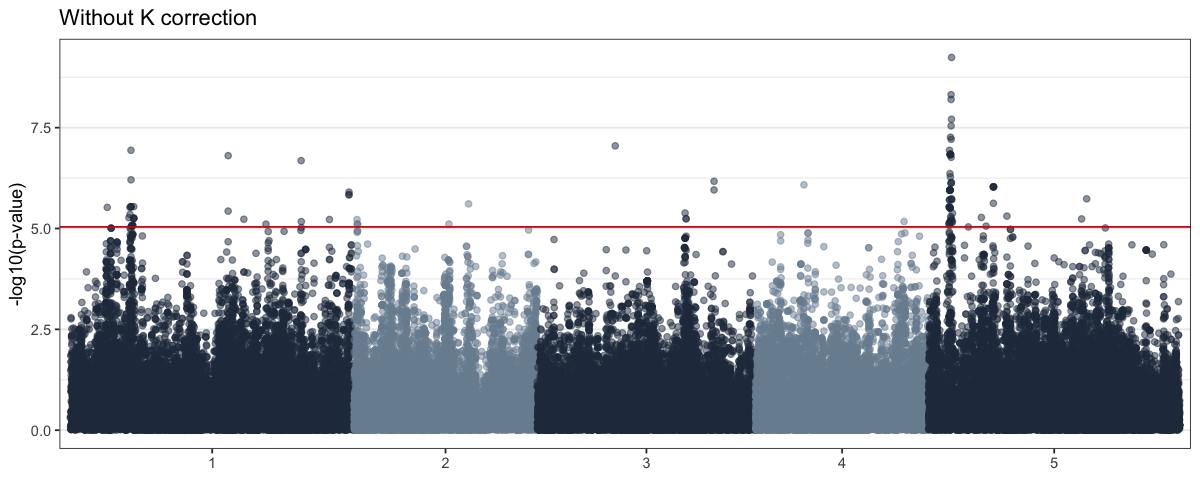

In [7]:
options(repr.plot.width=10, repr.plot.height=4)

p.man.nc = ggmanhattan(results.nc, s.title="Without K correction")
p.man.nc 

# Save the plot
pdf(paste(path.figures, 'manhattan_',s.phenotype,'_no_kinship.pdf', sep = ''), width = 8, height = 4)
p.man.nc
dev.off()


# 6. Effect of minor allele frequency cutoff

## (Don't run this section in independent work - requires pre-run results)

Why do we take a minor allele frequency (MAF) cutoff?  First, low frequency SNPs can have complicated LD patterns with many other SNPs. As a results, they are more likely to be false positives due to confounding, which can be seen in p-value inflation.  Second, we have less power when testing low frequency SNPs given the low sample size of the minor allele.  Testing these SNPs therefore adds to our multiple testing correction problem without giving us much useful information in return.

Let's look at a Manhattan plot to see what happens to p-values if we lower the cutoff from 10% to 1%.  The Bonferroni cutoff is much higher because we test many more SNPs.  There are also many more high p-value SNPs that don't seem to be associated with a peak - these are likely false positives due to confounding.

pdf 
  2

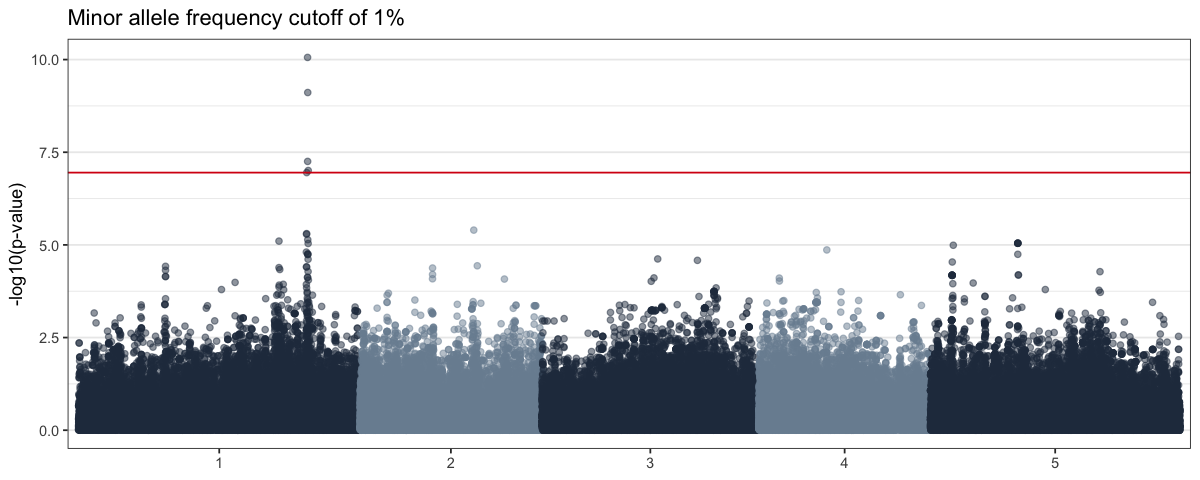

In [8]:
p.man.maf1 = ggmanhattan(results.maf1, s.title="Minor allele frequency cutoff of 1%")
p.man.maf1 

pdf(paste(path.figures, 'manhattan_',s.phenotype,'_maf1.pdf', sep = ''), width = 8, height = 4)
p.man.maf1
dev.off()

The QQ plot also reflects this inflation (compare with the 10% MAF cutoff in our original GWAS on the left).

pdf 
  2

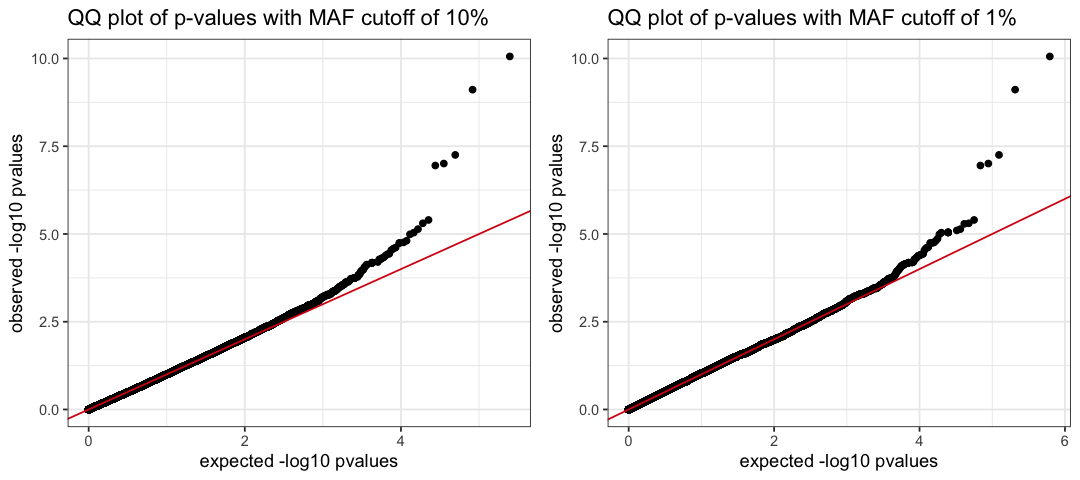

In [9]:
options(repr.plot.width=9, repr.plot.height=4)

p.qq = qqplot(results, s.title = "QQ plot of p-values with MAF cutoff of 10%")
p.qq.maf1 = qqplot(results.maf1, s.title = "QQ plot of p-values with MAF cutoff of 1%")

grid.arrange(p.qq, p.qq.maf1, ncol=2)

# Save plot
pdf(paste(path.figures, 'qq_',s.phenotype,'_maf.pdf', sep = ''), width = 9, height = 4)
grid.arrange(p.qq, p.qq.maf1, ncol=2)
dev.off()

# 7. P-value and effect size are not the same thing.

One mistake people often make when interpreting GWAS results is to assume that the SNP with the highest p-value explains more phenotypic variation than the others.  There is a relationship between the effect size of a SNP and its p-value, but this relationship is __not__ absolute.  Additionally, a SNP can be significantly-associated with a phenotype, yet not contribute very much to the *overall* phenotypic variation among the accessions tested.  It is therefore worth considering both the p-value *and* the effect size of a SNP you are interested in.

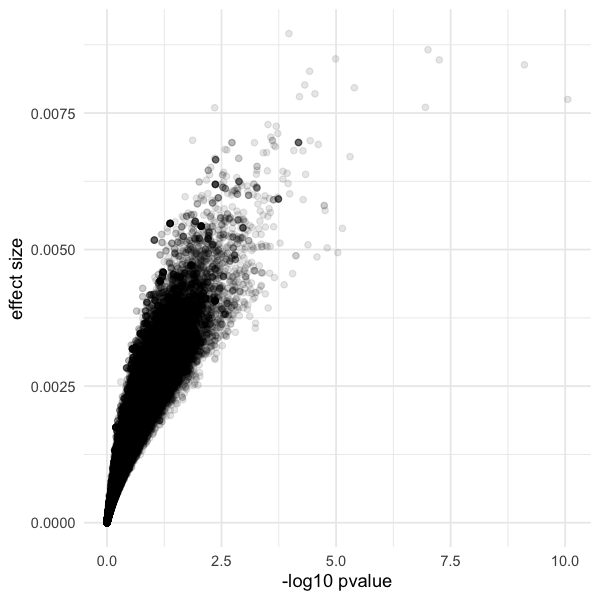

In [10]:
options(repr.plot.width=5, repr.plot.height=5)

p <- ggplot(results, aes(x = -log10(pvalue), y = abs(GVE))) +
  geom_point(alpha = 0.1) +
  xlab("-log10 pvalue") +
  ylab("effect size") +
  theme_minimal()

p

# Conclusion
In these three notebooks, we have explored a phenotype, used that phenotype for GWAS, and interpreted the resulting output.  For the rest of the class, you now have the chance to run these notebooks yourself with different phenotypes.